In [1]:
import typing
import lzma
import os
import dataclasses
import itertools
import functools
from importlib import reload
from pathlib import Path
from types import MappingProxyType, SimpleNamespace

import cbor2
import attrs
import tqdm.auto
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import jaxtyping as jt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arc25 import symmetry, tools as arc25_tools
from arc25.symmetry import D4, transform_vector
from arc25 import serialisation
from arc25.dsl.types import Vector, Dir4
from arc25.vision2.symrep import SymDecompBase, SplitSymDecomp, SymDecompDims, standard_rep, RepSpec
from arc25.vision2.fields import FieldDims, CoordinateGrid
from arc25.vision2.linear import SpaceSymmetricLinear, SpaceSymmetricTensor, SymmetryMappingSpec, SymDecompLinear
from arc25.vision2 import fields, attention, encoder, transformer, mae, swiglu
from arc25.training import saving, dataset, mae as mae_trainer, knn_eval

In [2]:

os.environ["XLA_FLAGS"]="--xla_force_host_platform_device_count=2"

In [3]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"

In [4]:
src_dataset = dataset.ImagesDataset.load_compressed_cbor(data_root/ "repack/re-arc.cbor.xz")

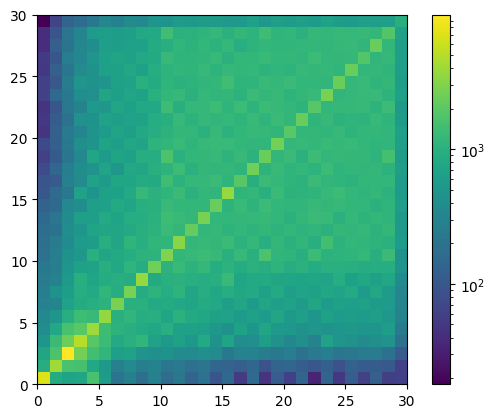

In [5]:

size_counts = src_dataset.size_counts(max_size=(30,30))

plt.pcolormesh(size_counts,norm="log")
plt.axis("square")
plt.colorbar()


In [6]:
import numba

def brute(size_counts,N=4):
    i = np.arange(1,31)
    ccounts = np.cumsum(np.cumsum(size_counts,axis=0),axis=1)
    ncells = i[:,None]*i
    total_cells = size_counts*ncells
    ccells = np.cumsum(np.cumsum(total_cells,axis=0),axis=1)
    mx = 30
    useful = ccells[mx-1,mx-1]
    cc = np.zeros((mx+1, mx+1),int)
    cc[1:,1:] = ccounts
    best, bestb = brute_impl(cc,mx,N)
    return useful, best, bestb
    
@numba.njit
def brute_impl(ccounts,mx,N):
    best = 30**2*ccounts[-1,-1]
    bestb = np.zeros(N,dtype=np.int_)
    j = np.arange(N+1, dtype=np.int64)
    j[-1] = mx
    while True:
        cc = ccounts[j,:][:,j]
        bc = cc[1:]-cc[:-1]
        bcnt = bc[:,1:]-bc[:,:-1]
        bsz = j[1:,None]*j[1:]
        spent = np.sum(bcnt*bsz)
        if spent < best:
            best = spent
            bestb = j[1:].copy()

        i = N-1
        # find rightmost position that can be incremented
        while i > 0 and j[i]+1 == j[i+1]:
            i -= 1
        if i <= 0:
            # already at the last combination
            break
        j[i] += 1
        # reset the tail to the minimal ascending values
        while i+1<N:
            j[i+1] = j[i] + 1
            i += 1
        
    return best, bestb

orthocost = []
for N in range(2,8):
    n_useful, n_spent, best = brute(size_counts, N=N)
    print(f"With {N=}, waste {(n_spent-n_useful)/1e6:.1f}/{n_spent/1e6:.1f} M (efficiency {100*n_useful/n_spent:.1f} %) with {best}")
    orthocost.append((N*(N+1)//2,n_spent))

orthocost = np.array(orthocost).T

With N=2, waste 199.2/422.9 M (efficiency 52.9 %) with [16 30]
With N=3, waste 121.2/344.9 M (efficiency 64.9 %) with [12 21 30]
With N=4, waste 86.3/310.0 M (efficiency 72.2 %) with [11 17 24 30]
With N=5, waste 64.7/288.4 M (efficiency 77.6 %) with [ 8 14 20 25 30]
With N=6, waste 50.7/274.4 M (efficiency 81.5 %) with [ 7 12 16 20 25 30]
With N=7, waste 41.5/265.3 M (efficiency 84.3 %) with [ 6 11 15 19 23 26 30]


array([[30, 30],
       [15, 29],
       [11, 19],
       [21, 30],
       [17, 22],
       [ 7, 12],
       [ 9, 30],
       [25, 29],
       [20, 25],
       [13, 24]])

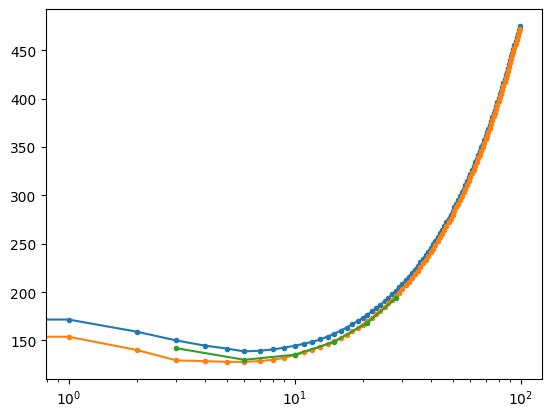

In [7]:
@numba.njit
def greedy_buckets(C, K):
    m, n = C.shape  # expect 30x30

    chosen = np.zeros((m, n), dtype=np.uint8)

    M = np.full((m, n), m*n, dtype=np.int64)
    chosen[m-1, n-1] = 1
    used = 1

    total_budget = max(1, K)

    buckets = np.empty((total_budget, 2), dtype=np.int64)
    total_cost = np.empty(total_budget, dtype=np.int64)
    buckets[0,:] = (m,n)
    total_cost[0] = m*n*C.sum()
    
    while used < total_budget:
        best_gain = 0
        bi = bj = -1

        for i in range(m):
            for j in range(n):
                if chosen[i, j]:
                    continue
                a = (i+1)*(j+1)
                # marginal gain over rectangle [0..i]x[0..j]
                gain = 0
                for u in range(i+1):
                    for v in range(j+1):
                        diff = M[u, v] - a
                        if diff > 0:
                            gain += C[u, v] * diff
                if gain > best_gain:
                    best_gain = gain
                    bi, bj = i, j

        if best_gain <= 0 or bi < 0:
            break

        # commit the best candidate, update M and parents
        chosen[bi, bj] = 1
        a = (bi+1)*(bj+1)
        for u in range(bi+1):
            for v in range(bj+1):
                if a < M[u, v]:
                    M[u, v] = a

        buckets[used,:] = (bi+1,bj+1)
        total_cost[used] = (M*C).sum()
        
        used += 1

    return buckets, total_cost

buckets, total_cost = greedy_buckets(size_counts,100)
i = np.r_[1:31]
upper = i[:,None] > i
ssc = np.where(~upper,size_counts,0)+np.where(upper,size_counts,0).T
sbuckets, stotal_cost = greedy_buckets(ssc,100)

train_examples = 4096 * 256
train_fraction = train_examples / size_counts.sum()
train_cell_rate = 30**2 * 79
compile_time = 4*60 # seconds

est_time = lambda y,x=None: (train_fraction*y/train_cell_rate + (np.r_[1:len(y)+1] if x is None else x)*compile_time)/60


plt.semilogx(est_time(total_cost),marker=".")
plt.plot(est_time(stotal_cost),marker=".")
plt.plot(orthocost[0],est_time(orthocost[1],orthocost[0]),marker=".")
#plt.axhline((i[:,None]*i*size_counts).sum(),c="r")
sbuckets[:10]

In [8]:
eval_split, train_split = src_dataset.split_by_challenge(
    np.random.default_rng(seed=42),
    n_min=2,
)

size_cuts = [12, 21, 30]
#size_cuts = [8,12,16,24,30]
#size_cuts = [30]

eval_ds = dataset.BucketedDataset.make(
    eval_split,
#    [(30,30)],
    set(itertools.product(size_cuts, size_cuts)),
)
print({k:v.n_examples for k,v in eval_ds.buckets.items()})

training_ds = dataset.BucketedDataset.make(
    train_split,
    set(itertools.product(size_cuts, size_cuts)),
)
print({k:v.n_examples for k,v in training_ds.buckets.items()})


{(30, 30): 86, (21, 30): 176, (21, 21): 111, (12, 12): 157, (12, 21): 119, (12, 30): 151}
{(30, 30): 93634, (21, 30): 176672, (21, 21): 105070, (12, 12): 158566, (12, 21): 144210, (12, 30): 120790}


In [9]:
width = FieldDims(
    context = SymDecompDims(
        space = 2*16,   # 8x2 = 16   
        flavour = 1*16, # 10x1 = 10
        invariant= 14*16, # 1x14 -> 40*16
    ),
    cells = SymDecompDims(
        space = 2*8,
        flavour = 1*8,
        invariant = 22*8, # -> 48*8
    ),
    context_tokens = 2,
)
    
arc_mae = mae.MaskedAutoencoder(
    num_heads=8,
    num_groups=2,
    num_layers=8,
    num_perceiver_layers=3,
    num_perceiver_tokens=8,
    num_decoder_layers=4,
    hidden_size=width,
    swiglu_width_factor=8/3,
    qk_head_width=SymDecompDims(
        space = 3 * 8,  # 1x3x8
        flavour = 1 * 4,  # 10x1x4 = 5x1x8 
        invariant = 4 * 8, # 1*4*8 -> 12x8
        rep=RepSpec(symmetry.ChiralityRep, 10)
    ),
    v_head_width=SymDecompDims(
        space = 2*4,
        flavour = 1*4,
        invariant = 14*4,
    ),
    use_chirality_rep=False,
    per_head_rope_freq=False,
    norm_per = "basis-nnx",
    dtype=jnp.float32,
    rngs=nnx.Rngs(42),
)

In [10]:
for fn in data_root.glob("models/*.msgpack.xz"):
    print(fn.name, fn.stat().st_size)

res = saving.load_model(data_root/"models"/"20251014-2041-nano-chkp-001536.msgpack.xz")
nnx.update(arc_mae, res.state.model)

20251011-2032-nano-1638.msgpack.xz 78541580
20251010-1443-nano-cls-final.msgpack.xz 69062808
20251014-2041-nano-chkp-001536.msgpack.xz 79012616
test-run-chkp-000016.msgpack.xz 78996672
20251010-1443-nano-cls-final-w-config.msgpack.xz 69065832
20251014-1444-chkp-000021-final.msgpack.xz 0
20251011-2032-nano-final.msgpack.xz 78469648
20251014-1444-chkp-000016.msgpack.xz 78994616
20251014-1518-chkp-000003-final.msgpack.xz 78983364
20251014-1533-chkp-000004-final.msgpack.xz 20980944
20251014-1454-chkp-000009-final.msgpack.xz 54744498
20251014-1541-chkp-000008-final.msgpack.xz 78976028
test-run-chkp-000005-final.msgpack.xz 78992408
test-run-chkp-000021-final.msgpack.xz 78956288
20251011-1953-nano-final.msgpack.xz 79213548
20251014-1513-chkp-000008-final.msgpack.xz 78984844


In [11]:
f = "5.2f"
for k,v in nnx.iter_graph(arc_mae):
    if isinstance(v, attention.AxialAttention):
        attn = v
        for kk,vv in attn.rope_freq_params.items():
            print(f"{".".join(k+(kk,))+":":64s} {vv.min():{f}} {vv.mean():{f}} {vv.std():{f}} {vv.max():{f}}")

decoder.blocks.self_attn.cells.flavour:                          -1.99 -0.58  0.81  0.79
decoder.blocks.self_attn.cells.invariant:                        -1.88  0.03  0.87  1.73
decoder.blocks.self_attn.cells.space:                            -1.99  0.10  0.84  1.87
encoder.main_stack.blocks.self_attn.cells.flavour:               -1.79 -0.17  0.92  1.78
encoder.main_stack.blocks.self_attn.cells.invariant:             -1.91  0.04  0.86  1.90
encoder.main_stack.blocks.self_attn.cells.space:                 -1.89  0.01  0.84  1.96


In [12]:
config = mae_trainer.MAETaskConfig(
    seed = 42,
    
    batch_size = 16,
    ref_batch = 16,
    minibatch_size = 16,
    base_cell_cost = 10, 
        
    learning_rate = 1e-5,
    max_num_epochs = 1,
    max_num_ref_batches = 128,

    warmup_steps = 64,
    checkpoint_every_steps = 16,
    knn_validation_every_ref_batch = 2,
    
    mode="flat",
    remat=True,
    unroll=None,

    test_ratio = 0.25,
    nonmask_fraction = 0.2,
    randomise_fraction = 0.2,
)



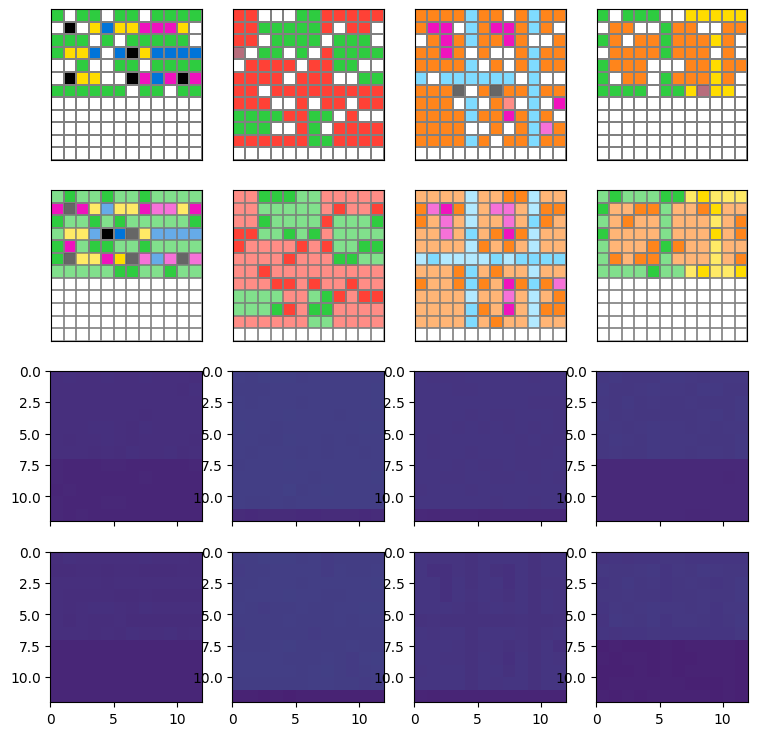

In [13]:
reload(mae_trainer)

# Create collator with proper seed and granularity
minibatch_size_fn = dataset.MinibatchSizeFunction(
    reference_minibatch_size=32,
#    reference_image_size=config.reference_image_size,
#    base_cost=config.base_cell_cost,
#    granularity=1,  # Ensure divisibility for pmap
)

batch_spec = dataset.BatchSpec(
    target_batch_weight=config.batch_size,
    reference_image_size=config.reference_image_size,
    # Hard-code area_weight_exponent=0.5 (heuristic: sqrt scaling)
    area_weight_exponent=0.5,
)

collator = dataset.BucketedCollator.make(
    dataset=training_ds,
    batch_spec=batch_spec,
    minibatch_size=minibatch_size_fn,
    seed=config.seed,  # Tie dataset seed to training seed
)

# Initialize trainer
trainer = mae_trainer.MAETrainer.make(
    config=config,
    model=arc_mae,
    collator=collator,
    num_devices=2,
    eval_dataset=eval_ds,
    minibatch_size_fn=minibatch_size_fn,
    rngs=np.random.default_rng(config.seed),
    lr_schedule=None,
)

reload(arc25_tools)

batch = next(iter(trainer.collator.generate()))
tmb = batch.minibatches[0]
imb, = [SimpleNamespace(**dct) for dct in trainer.prepare_mae_batch([tmb])]
fig,axes = plt.subplots(4,4,figsize=(9,9),sharex="col",sharey="col")

pred,attn = arc_mae(imb.images, imb.sizes, mask=imb.input_mask, with_attention_maps=True)

for i,axe in enumerate(axes.T,0):
    s = np.s_[i,:12,:12]
    inp = np.where(imb.input_mask[s],imb.images[s],np.nan)
    mi = (imb.images[s] == tmb.images[s]) | ~imb.input_mask[s]
    tgt = np.where(tmb.masks[s],tmb.images[s],np.nan)
    mt = imb.prediction_mask[s]
    for ax, (v,m) in zip(axe[:2], [(inp,mi),(tgt,mt)]):
        arc25_tools.show_image(v,ax=ax,alpha=np.where(m,1.0,0.6))

    p = jax.nn.softmax(pred[s],axis=-1)
    for ax,v in zip(
        axe[2:],
        [
            p.max(-1),
            np.take_along_axis(p,tmb.images[s][...,None],axis=-1)[...,0]
        ],
    ):
        ax.pcolormesh(v,vmin=0,vmax=1)


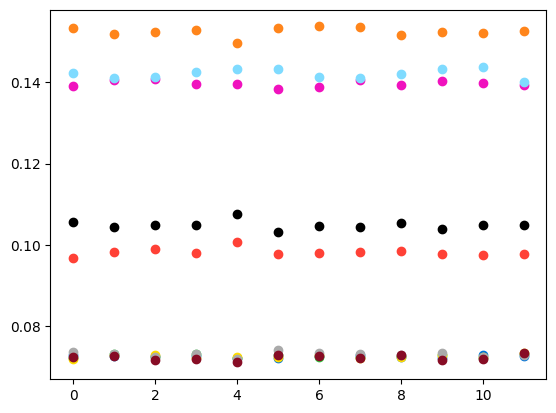

In [15]:
p = jax.nn.softmax(pred[2,6,:12],axis=-1)
for j in range(10):
    plt.plot(p[:,j],'o',c=arc25_tools._cmap(j))

(105, 8, 12, 21, 4, 1) (105, 8, 12, 21, 1)
(105, 8, 12, 21, 6)


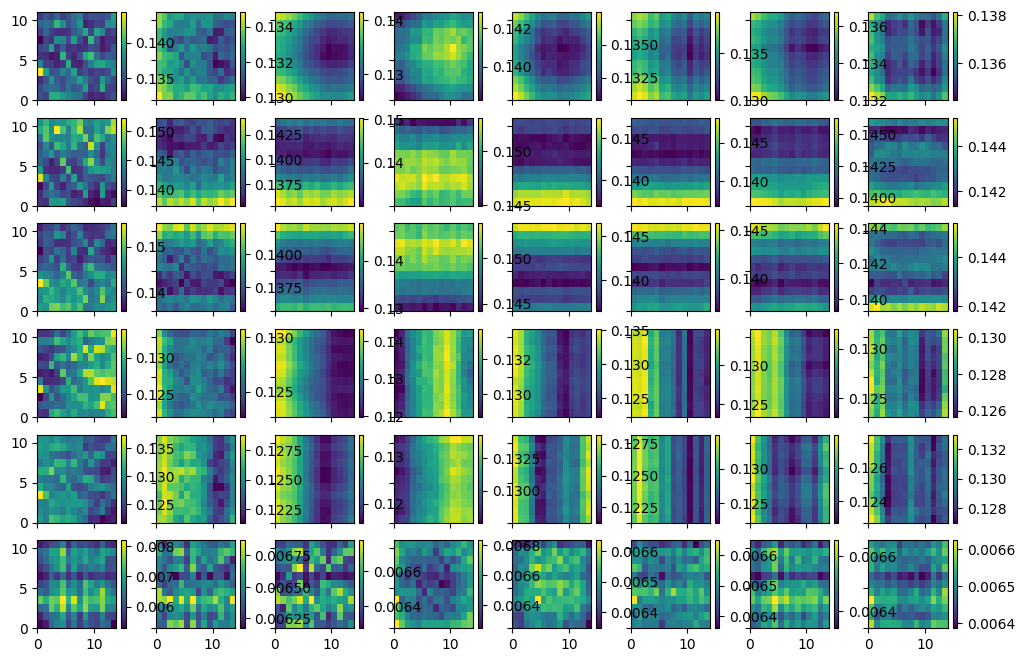

In [49]:
main_cells = attn["encoder"]["main"]["attention_maps"]["sa_maps"]["cells"]
main_context = attn["encoder"]["main"]["attention_maps"]["ca_maps"]["cells"]
print(main_cells.shape, main_context.shape)
attn_map = np.concatenate([
    main_cells.mean((-2,-1))[...,None],
    main_cells.reshape(*main_cells.shape[:-2],-1),
    main_context.reshape(*main_context.shape[:-1],-1),
],axis=-1)
print(attn_map.shape)

fig,axes = plt.subplots(6,8,figsize=(12,8),sharex=True, sharey=True)
i = 1
for j,axe in enumerate(axes.T):
    for k, ax in enumerate(axe):
        v = attn_map[i,j,:11,:14,k]
        plt.colorbar(ax.pcolormesh(v),ax=ax)


(105, 3, 12, 21, 1)
(105, 3, 12, 21, 1)


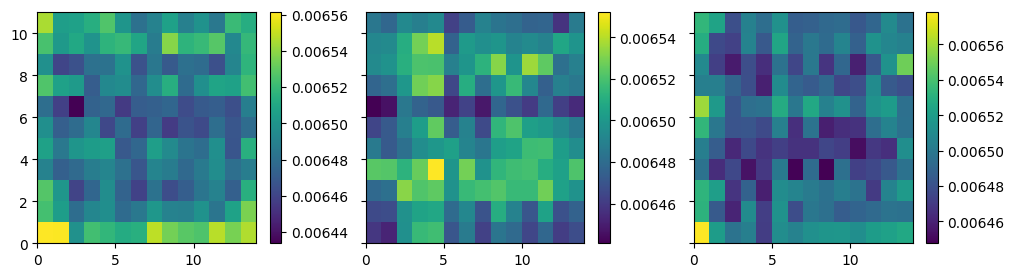

In [40]:
perceiver_cells = attn["encoder"]["perceiver"]["attention_maps"]["ca_maps"]["cells"]
print(perceiver_cells.shape)
attn_map = np.concatenate([
    perceiver_cells.reshape(*perceiver_cells.shape[:-1],-1),
],axis=-1)
print(attn_map.shape)

fig,axes = plt.subplots(1,3,figsize=(12,3),sharex=True, sharey=True, squeeze=False)
i = 1
for j,axe in enumerate(axes.T):
    for k, ax in enumerate(axe):
        v = attn_map[i,j,:11,:14,k]
        plt.colorbar(ax.pcolormesh(v),ax=ax)


(105, 4, 12, 21, 4, 1)
(105, 4, 12, 21, 5)


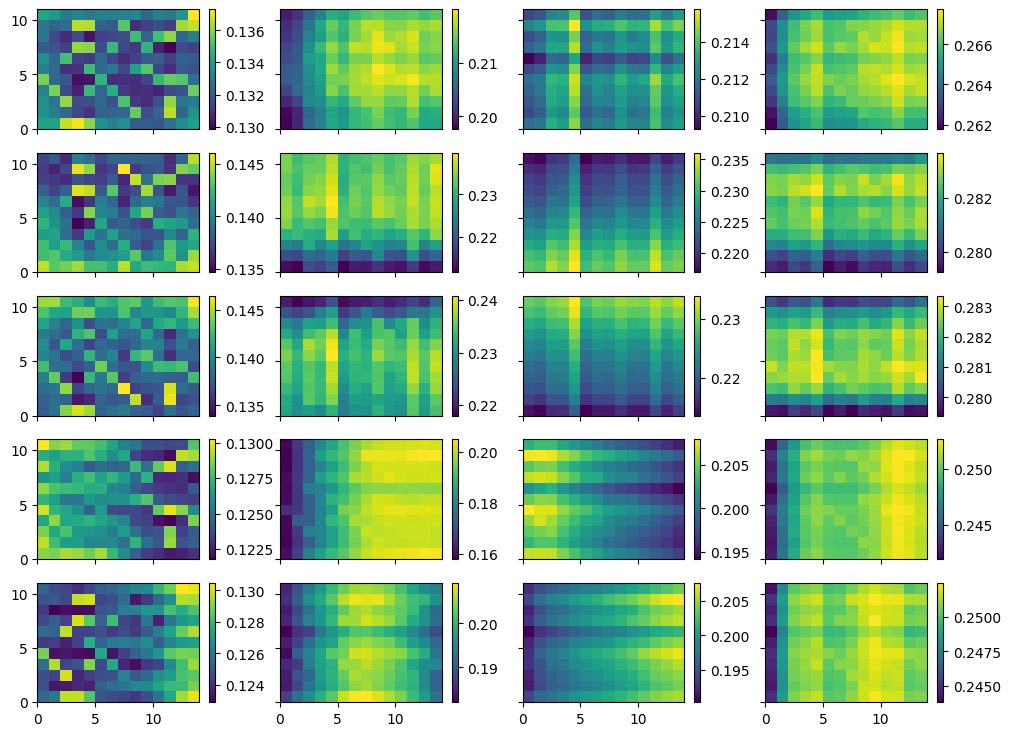

In [48]:
decoder_cells = attn["decoder"]["attention_maps"]["sa_maps"]["cells"]
print(decoder_cells.shape)
attn_map = np.concatenate([
    decoder_cells.mean((-2,-1))[...,None],
    decoder_cells.reshape(*decoder_cells.shape[:-2],-1),
],axis=-1)
print(attn_map.shape)

fig,axes = plt.subplots(5,4,figsize=(12,9),sharex=True, sharey=True, squeeze=False)
i = 1
for j,axe in enumerate(axes.T):
    for k, ax in enumerate(axe):
        v = attn_map[i,j,:11,:14,k]
        plt.colorbar(ax.pcolormesh(v),ax=ax)


In [16]:
asdfasd

NameError: name 'asdfasd' is not defined

In [ ]:
import humanize

if False:
    layer = arc_mae.encoder.main_stack.blocks
    gs,state = nnx.split(layer)
    state = jax.tree.map(lambda v:v[0],state)
    layer = nnx.merge(gs,state)
    
    x = width.make_empty(batch=(1,),shape=(30,30))
    def test_fun(model,x,**kw):
        return model(x,**kw,mode=mode)
    def unpack(obj,path=()):
        match obj:
            case SimpleNamespace():
                yield from unpack(vars(obj),path)
            case dict():
                for k,v in obj.items():
                    yield from unpack(v,path+(k,))
            case SymDecompLinear():
                yield path,obj.approximate_flops
            case nnx.Linear():
                yield path,obj.kernel.size
            case _:
                print(f"Ignoring {type(obj).__name__}")
    if True:
        attn = layer.self_attn.cells
        tot = 0
        for k,v in unpack(dict(q=attn.q,k=attn.k,v=attn.v,out=attn.out)):
            N = 30
            fac = N*N
            tot += v*fac
            print(f"{'.'.join(k)}: {humanize.naturalsize(v*fac)}")
        print(f"Total attention projections: {humanize.naturalsize(tot)}")
    for mode in [None,"split","flat"]:
        print(f">> Mode: {mode}")
        compiled = nnx.jit(test_fun).trace(layer.self_attn.cells,x.cells,grid=x.grid,deterministic=True).lower().compile()
        print(f"Total attn: {humanize.naturalsize(compiled.cost_analysis()["flops"])}")
        compiled = nnx.jit(test_fun).trace(layer.swiglu.cells,x.cells,rngs=nnx.Rngs(0)).lower().compile()
        print(f"Total SwiGLU: {humanize.naturalsize(compiled.cost_analysis()["flops"])}")
        compiled = nnx.jit(test_fun).trace(layer,x,rngs=nnx.Rngs(0)).lower().compile()
        print(f"Total Layer: {humanize.naturalsize(compiled.cost_analysis()["flops"])}")

In [ ]:
import humanize


def print_stats(stats,path=()):
    for k,v in vars(stats).items():
        p = path+(k,)
        if isinstance(v, SimpleNamespace):
            print_stats(v, p)
            continue
        if v is None:
            continue
        if p[0] == "model":
            va = {"":v}
        else:
            va = dict(batch=v,example=v/config.global_batch_size)
        msg = []
        for kk,vv in va.items():
            if "bytes" in k:
                n = humanize.naturalsize(vv,binary=True)
            else:
                n = humanize.naturalsize(vv,gnu=True,format="%.1f ")
                if n.endswith("B"):
                    n = n[:-1]+" "
            if "flops" in k:
                n += "FLOPs"
            if kk:
                n += f" ({kk})"
            msg.append(n)
        n = "".join(f"{n:25s}" for n in msg)
        print(f"{'.'.join(p):32s}: {n}")

if False:
    ts = mae_trainer.TrainState.make(model=arc_mae, config=config, rngs=nnx.Rngs(0))
    stats = SimpleNamespace(model=ts.model_stats(),batch=ts.batch_stats())
    leaves = [
        a for p in width.make_empty(
            batch=(config.global_batch_size,),
            shape=(30,30),
        ).projections.values() for a in p.representations.values()
    ]
    stats.fields = SimpleNamespace(params=sum(a.size for a in leaves),bytes=sum(a.nbytes for a in leaves))
    print_stats(stats)

In [ ]:
reload(knn_eval)
reload(mae_trainer)

if True:
    train_state, stats = mae_trainer.MAETrainer.main(
        model=arc_mae,
        config=config,
        dataset=training_ds,
        eval_dataset=eval_ds,
        run_name="test-run",
        checkpoint_dir=data_root/"models",
    )

In [ ]:
np.eye(4,dtype=bool)

In [ ]:
%debug

In [ ]:
asdfas

In [ ]:
ds = make_dataset(4*30**2, multiplier=1, mask_ratio=0.4, rngs=nnx.Rngs(42))
batch, _, _ = next(ds)
out, stats = arc_mae(batch["image"],batch["size"], mask=batch["input_mask"], with_stats=True)

In [ ]:
i = 2
fig,axes = plt.subplots(1,3,figsize=(12,3))
img = batch["image"][i]
im = batch["input_mask"][i]
pm = batch["prediction_mask"][i]
for ax,v in zip(axes,[np.where(im|pm,img,np.nan),np.where(im,img,np.nan),np.where(pm,img,np.nan)]):
    ax.pcolormesh(v)

In [ ]:
p = jax.nn.softmax(out[i],axis=-1)
v = p
fig,axes = plt.subplots(2,5,figsize=(12,3))
for j,ax in enumerate(axes.ravel()[:10]):
    plt.colorbar(ax.pcolormesh(np.where(pm,v[...,j],np.nan),vmin=0,vmax=1))